In [15]:
from glob import glob
import numpy as np
import os
from pathlib import Path
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random

In [3]:
with open('dictionary_new.pkl', 'rb') as f:
    token2id, id2token = pickle.load(f)

In [10]:
def group_bar(tokens):
    groups = []
    cur_group = []

    assert tokens[0] == 'Bar_None'
    cur_group.append(tokens[0])

    for t in tokens[1:]:
        if t == 'Bar_None':
            groups.append(cur_group)
            cur_group = []
        cur_group.append(t)

    if cur_group:
        groups.append(cur_group)
        
    return groups

def full2sky(tokens):
    return list(filter(lambda t: not t.startswith('Velocity') and not t.startswith('Tempo'), tokens))

In [14]:
BAR_LEN = 160

cond_data = []
target_data = []

for full_path in tqdm(glob('dataset/pop2piano_data/remi_events_full/*/*.pkl')):
    sky_path = full_path.replace('remi_events_full', 'remi_events_sky')

    full_tokens = np.load(full_path, allow_pickle=True)
    sky_tokens = np.load(sky_path, allow_pickle=True)

    full_tokens = [f'{t["name"]}_{t["value"]}' for t in full_tokens]
    sky_tokens = [f'{t["name"]}_{t["value"]}' for t in sky_tokens]
    
    full_groups = group_bar(full_tokens)
    sky_groups = group_bar(sky_tokens)

    assert len(sky_groups) <= len(full_groups)

    while len(sky_groups) < len(full_groups):
        sky_groups.append(full2sky(full_groups[len(sky_groups)]))
        
    tempo_token = next((t for t in full_tokens if t.startswith('Tempo')), None)
    assert tempo_token is not None

    cond_tokens = ['[BOS]', tempo_token]
    for group in sky_groups:
        cond_tokens.append('Track_Skyline')
        cond_tokens += group
    cond_tokens.append('[EOS]')

    target_tokens = []
    for full_group in full_groups:
        target_tokens.append('Track_Midi')
        target_tokens += full_group
        target_tokens += ['[NONE]'] * (BAR_LEN - len(full_group))

    cond_data.append(' '.join(cond_tokens))
    target_data.append(' '.join(target_tokens))

indices = list(range(len(cond_data)))
random.shuffle(indices)
train_size = int(len(indices) * 0.8)
train_indices = indices[:train_size]
valid_indices = indices[train_size:]

with open('cond_train.txt', 'w') as f:
    for i in train_indices:
        f.write(cond_data[i] + '\n')

with open('target_train.txt', 'w') as f:
    for i in train_indices:
        f.write(target_data[i] + '\n')

with open('cond_valid.txt', 'w') as f:
    for i in valid_indices:
        f.write(cond_data[i] + '\n')

with open('target_valid.txt', 'w') as f:
    for i in valid_indices:
        f.write(target_data[i] + '\n')


100%|██████████| 1392/1392 [00:06<00:00, 218.30it/s]


In [2]:
import pickle
with open('/tmp2/b11902010/dmir_lab/diffusion_compose_and_embellish/dictionary_all.pkl', 'rb') as f:
    d = pickle.load(f)
token2id, id2token = d
voc = [id2token[i] for i in range(len(id2token))]
voc = ['[MASK]', '[PAD]', '[NONE]', '[BOS]', '[EOS]'] + voc
token2id = {t: i for i, t in enumerate(voc)}
id2token = {i: t for i, t in enumerate(voc)}

with open('dictionary_new.pkl', 'wb') as f:
    pickle.dump((token2id, id2token), f)

(array([ 22.,  85., 193., 265., 194., 157.,  96.,  67.,  28.,   6.]),
 array([ 6279.,  8211., 10143., 12075., 14007., 15939., 17871., 19803.,
        21735., 23667., 25599.]),
 <BarContainer object of 10 artists>)

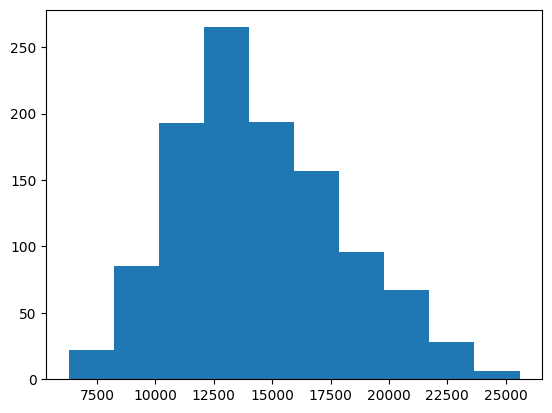

In [17]:
with open('dataset/pop2piano_data/target_train.txt', 'r') as f:
    dist = [len(l.split()) for l in f]

plt.hist(dist)